# Profiling

This notebook provides a simple version of an asynchronous model of prestige-reinforcement in networked endorsement dynamics, as exemplified by the faculty hiring process. 

This notebook is intentionally designed to expose all calculations, so all functions etc. (other than SpringRank) are defined in here directly. 

In [1]:
import numpy as np
from numba import jit


from py.simulation import *
from py.estimation import *
from py.features import *
from py.utils import *
from py.model import model

import cProfile

from SpringRank import SpringRank

from matplotlib import pyplot as plt

In [2]:
# Params

n = 5
n_rounds = 500
m_updates = 1
A = np.sqrt(np.random.rand(n,n))
A0 = A/A.sum()
lam = .995

In [10]:
@jit(nopython=True)
def homebrew_SpringRank(A, alpha):
    Di = np.diag(A.sum(axis = 0))
    Do = np.diag(A.sum(axis = 1))
    L = Di + Do - A - A.T + alpha*np.eye(A.shape[0])
    return(np.linalg.inv(L).dot(Do - Di).dot(np.ones(A.shape[0])))

In [11]:
A = np.random.rand(n,n)
homebrew_SpringRank(A.T, alpha = .0001)

<ipython-input-10-051843f101c6>:6: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  return(np.linalg.inv(L).dot(Do - Di).dot(np.ones(A.shape[0])))


array([ 0.04876716,  0.20011324, -0.09800409,  0.13769909, -0.10335942,
       -0.21795335, -0.05319701, -0.10410921,  0.02627999,  0.16376361])

In [12]:
SpringRank.SpringRank(A.T, alpha = .0001)

array([ 0.04876672,  0.2001131 , -0.09800456,  0.13769917, -0.10335886,
       -0.21795313, -0.05319711, -0.10410849,  0.02628016,  0.16376301])

In [13]:
ralpha = 10**(-7)
SpringRank_score = lambda A: SpringRank.SpringRank(A.T, alpha = ralpha)
homebrew_SpringRank_score = lambda A: homebrew_SpringRank(A.T, alpha = ralpha)
linear_feature = lambda s: np.tile(s,(len(s), 1))

# root_degree_score = lambda A: np.sqrt(A.sum(axis = 0))


M = model()
M.set_score(score_function = homebrew_SpringRank_score)
M.set_features([linear_feature])

In [14]:
n = 10
n_rounds = 5000
m_updates = 1
A = np.sqrt(np.random.rand(n,n))
A0 = A/A.sum()
lam = .97
beta = 3

In [15]:
cmd = 'M.simulate(beta = np.array([beta]), lam = lam, A0 = A0, n_rounds = n_rounds, update = deterministic_update, m_updates = m_updates)'

In [16]:
cProfile.run(cmd)

         250011 function calls (245011 primitive calls) in 1.250 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     5000    0.008    0.000    0.040    0.000 <__array_function__ internals>:2(dot)
     5000    0.009    0.000    0.410    0.000 <__array_function__ internals>:2(tensordot)
     5000    0.008    0.000    0.141    0.000 <__array_function__ internals>:2(tile)
     5000    0.172    0.000    0.172    0.000 <ipython-input-10-051843f101c6>:1(homebrew_SpringRank)
     5000    0.042    0.000    0.215    0.000 <ipython-input-13-30008af30239>:3(<lambda>)
     5000    0.013    0.000    0.157    0.000 <ipython-input-13-30008af30239>:4(<lambda>)
        1    0.000    0.000    1.250    1.250 <string>:1(<module>)
    10000    0.006    0.000    0.012    0.000 _asarray.py:16(asarray)
     5000    0.004    0.000    0.070    0.000 _methods.py:36(_sum)
        1    0.326    0.326    1.249    1.249 model.py:42(simulate)
     5000   

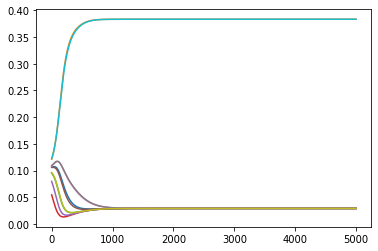

In [105]:
plt.plot(M.GAMMA.mean(axis = 1))

In [84]:
# features

linear_feature = lambda s: np.tile(s,(len(s), 1))
def quadratic_feature(s):
    S = linear_feature(s)
    F = (S - S.T)**2
    return(F)


In [97]:
n = 10

A0 = np.random.rand(n,n)
A0 = A0/A0.sum()

lam = .97
n_rounds = 10000

b_grid = 101
BETAS = np.linspace(1,3, b_grid)

V = np.zeros((b_grid, n))

M = model()
M.set_score(score_function = SpringRank_score)
M.set_features([linear_feature])

for j in range(b_grid):

    M.simulate(beta = np.array([BETAS[j]]), 
                       lam = lam, 
                       A0 = A0, 
                       n_rounds = n_rounds, 
                       update = deterministic_update, 
                       m_updates = m_updates)
    GAMMA = M.get_rates()
    GAMMA = np.sort(GAMMA, axis = 2)
    V[j] = GAMMA[-1].mean(axis = 0)

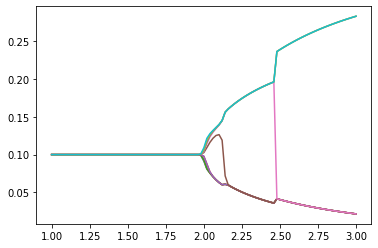

In [98]:
p = plt.plot(BETAS, V)

In [100]:
V[-1]

array([0.02154211, 0.02154211, 0.02154211, 0.02154211, 0.02154211,
       0.02154211, 0.02154211, 0.2830651 , 0.28307001, 0.28307011])

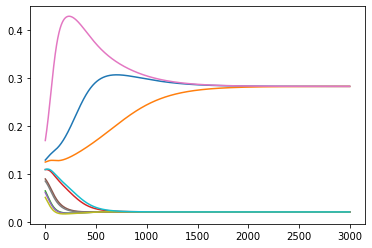

In [93]:
n_rounds = 3000

T = M.simulate(beta = np.array([3]), 
                   lam = lam, 
                   A0 = A0, 
                   n_rounds = n_rounds, 
                   update = deterministic_update, 
                   m_updates = m_updates)

GAMMA = M.get_rates()
GAMMA = GAMMA.mean(axis = 1)
plt.plot(GAMMA)

In [132]:


transition_predictions = {
    'SpringRank': 2 + n*ralpha, 
    'Root-Degree': 2*n**(1/2),
    'PageRank': n # not derived in any meaningful way yet
}

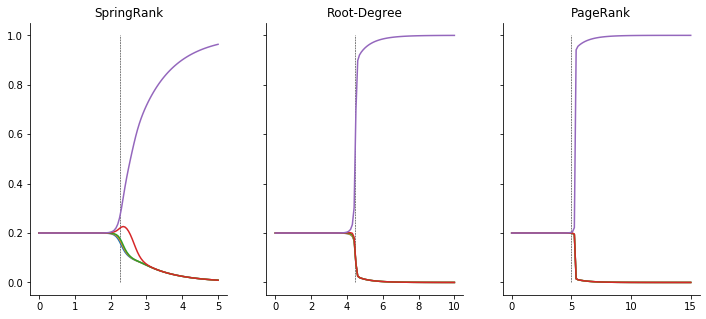

In [133]:
b_grid = 101

BETAS = {
    'SpringRank' : np.linspace(0, 5, b_grid), 
    'Root-Degree': np.linspace(0,10, b_grid),
    'PageRank' : np.linspace(0, 15, b_grid)
}

score_names = list(scores.keys())

k = len(score_names)

fig, axarr = plt.subplots(1,k, figsize = (12, 5), sharey = True)

for i in range(k):

    M = model()
    M.set_score(score_function = scores[score_names[i]])
    M.set_features([linear_feature])
    
    V = np.zeros((b_grid, n))
    
    for j in range(b_grid):
        M.simulate(beta = np.array([BETAS[score_names[i]][j]]), 
                   lam = lam, 
                   A0 = A0, 
                   n_rounds = n_rounds, 
                   update = deterministic_update, 
                   m_updates = m_updates)
        GAMMA = M.get_rates()
        GAMMA = np.sort(GAMMA, axis = 2)
        V[j] = GAMMA[-1].mean(axis = 0)
    
    p = axarr[i].plot(BETAS[score_names[i]], V)
    
    v = axarr[i].vlines(x = [transition_predictions[score_names[i]]], 
                        ymin = 0, 
                        ymax = 1, 
                        linewidth = 0.5, 
                        linestyle = 'dashed')
    
    t = axarr[i].set_title(score_names[i])
    
    axarr[i].spines['top'].set_visible(False)
    axarr[i].spines['right'].set_visible(False)
    

plt.savefig('fig/phase_transitions.png')